# Import package 

In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from qm import generate_qua_script

#General os library 
import os
import time
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_first_jump_sticky import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element

#Path for HQCPC7 
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function

#Path for HQC PC15 
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
#import AnFunc as an 
import scipy.io
from scipy import signal 
from scipy.optimize import curve_fit

In [4]:
def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["twoPhoton_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""
    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm

# OPX configuration

In [5]:
#Octave & OPX configuration 
Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\\"
Cooldown_Date="2023_04_14"


opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave


qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
octave_output_gain=-10

qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-04-26 17:27:09,961 - qm - ERROR - Failed to connect to QuantumMachines server. Tried connecting to 128.178.175.167:81


Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\qm\run_async.py", line 32, in run
    self.result = asyncio.run(self.func)
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\asyncio\runners.py", line 43, in run
    return loop.run_until_complete(main)
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\asyncio\base_events.py", line 587, in run_until_complete
    return future.result()
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\qm\info_service\client.py", line 29, in get_server_info
    response = await service.get_info(get_info_request)
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\qm\io\qualang\api\v1\__init__.py", line 56, in get_info
    metadata=metadata,
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages

Exception: Failed to connect to QuantumMachines server. Tried connecting to 128.178.175.167:81

In [66]:
#Setting the gain
gain=-6
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

time_of_flight=24

config, qm=update_time_of_flight(time_of_flight,config,qmm)

pulse_amp=0.25
config,qm=update_pulse_amplitude(pulse_amp,config,qmm)


# Display parameters

In [34]:
print("LO of resonator : {} GHz".format(config['elements']['resonator']["mixInputs"]["lo_frequency"]/1e9))
print("IF of resonator : {} GHz".format(config['elements']['resonator']['intermediate_frequency']/1e9))
print("Time of flight of resonator : {} ns".format(config['elements']['resonator']['time_of_flight']))
print("Readout time resonator : {} ns".format(config["pulses"]["zero_pulse"]["length"]))
print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Ramping time of fluxline : {} ns".format(config['elements']['fluxline']['hold_offset']))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

#print("Input attenuation: {} dB".format(config['controllers']['con1']['analog_inputs'][1]["gain_db"]))

LO of resonator : 4.2 GHz
IF of resonator : 0.318 GHz
Time of flight of resonator : 24 ns
Readout time resonator : 2000 ns
LO of fluxline: 8.5 GHz
IF of fluxline : 0.1959 GHz
Ramping time of fluxline : {'duration': 5000} ns
Fluxline pulse time : 1000 ns
Fluxline amplitude : 0.125 V


# Testing the pump 

In [5]:
#Mixer Calibration 
#Calibration of the fluxline mixer for the pump 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-04-25 18:57:11,579 - qm - INFO - Flags: 
2023-04-25 18:57:11,580 - qm - INFO - Compiling program
2023-04-25 18:57:14,656 - qm - INFO - Sending pre-compiled program to QOP


In [3]:
# Testing the pump 
with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.1), 'fluxline')
        
job = qm.execute(TwoPhoton)

2023-04-21 16:14:28,195 - qm - INFO - Flags: 
2023-04-21 16:14:28,196 - qm - INFO - Sending program to QOP
2023-04-21 16:14:28,224 - qm - INFO - Executing program


In [92]:
#Two stop the two photon pumping 
job.halt()

NameError: name 'job' is not defined

# Downsweep 

## Single downsweep 

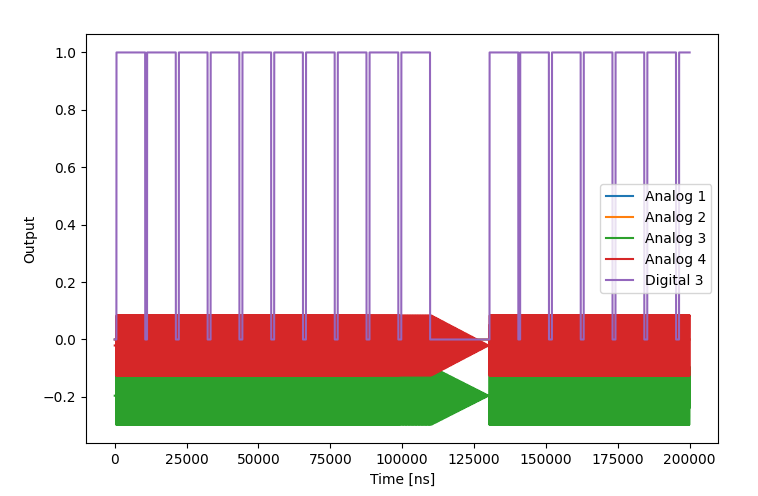

In this code, we create a pulse and update its frequency. At each frequency step, the pulse is played for its full pulse length. Simultaenously, we perform a readout. Then, there is a waiting time and we update the next frequency. In this case, the readout time can be very short because we do not need to wait until we reach the steady state. Addtionnally, it should be shorter than the typical jumping rate otherwise, we will average out some jumps. 

In [168]:
#Set the readout length and photon length 
Readout_Len=1_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

amp_factor=0.4

n_repetition=100000

IF_pump=190e6 #Ending frequency 
IF_right=197e6 # Starting frequency  
pump_step=0.1e6 # frequency step 
wait_pump_step=400//4 #w aiting time after having played the pump 

number_frequency=int(np.ceil((IF_right-IF_pump)/pump_step)) # number of frequency 

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

time_per_iteration=((wait_pump_step+twoPhoton_len)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

Time per iteration : 7.7e-05 s
Total time : 0.12833333333333333 min


In [169]:
%matplotlib qt


with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    
    # loop over multiple frequencies 
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        #Play the first pulse of the sticky to set the pump frequency and the amplitude 
        update_frequency("fluxline", IF_right)
        play("pumping"*amp(amp_factor), "fluxline") 
        
        #Freuqnecy steps 
        with for_(f, IF_right, f>IF_pump, f-pump_step):

            assign(f_readout,LO_diff+f/2) #update the readout frequency 
            update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 
            
            #update the sticky 
            update_frequency("fluxline", f, keep_phase=True)
            play("pumping"*amp(0), "fluxline")

        #Continously measure in paralell
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            wait(wait_pump_step, "fluxline") #time that will be waited after playing the pump 
            
            #Take absolute value of I and Q
            assign(I,Math.abs(I))
            assign(Q,Math.abs(Q))

            save(I, I_st)
            save(Q, Q_st)  
            save(f, f_st)
        
        #ramp to zero 
        ramp_to_zero("fluxline")

        save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).average().save("I")
        Q_st.buffer(number_frequency).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False     

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'3'})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        Id = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Qd = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.plot(f/1e6,np.sqrt(Id**2+Qd**2)*1e3,".", markersize=2)
        plt.xlabel("Pump frequency [MHz]")
        plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
        plt.pause(0.1)
       

2023-04-26 14:41:08,919 - qm - INFO - Flags: 
2023-04-26 14:41:08,920 - qm - INFO - Sending program to QOP
2023-04-26 14:41:09,245 - qm - INFO - Executing program
Execution stopped by user!


## Down sweep map

In [170]:
#Set the readout length and photon length 
Readout_Len=1_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


a_min=0.2
a_max=0.4
da=0.01
amp_factor=np.arange(a_min,a_max,da)

n_repetition=100000

IF_pump=185e6 #Ending frequency 
IF_right=197e6 # Starting frequency  
pump_step=0.1e6 # frequency step 
wait_pump_step=400//4 #w aiting time after having played the pump 

number_frequency=int(np.ceil((IF_right-IF_pump)/pump_step)) # number of frequency 

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

time_per_iteration=((wait_pump_step+twoPhoton_len)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition*len(amp_factor)/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

Time per iteration : 0.000132 s
Total time : 4.4 min


In [171]:
%matplotlib qt


with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    a= declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    
    # Averaging loop  
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        #loop over amplitude 
        with for_(*from_array(a, amp_factor)):
        
            #Play the first pulse of the sticky to set the pump frequency and the amplitude 
            update_frequency("fluxline", IF_right)
            play("pumping"*amp(a), "fluxline") 

            #loop over frequencies  
            with for_(f, IF_right, f>IF_pump, f-pump_step):

                assign(f_readout,LO_diff+f/2) #update the readout frequency 
                update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

                #update the sticky 
                update_frequency("fluxline", f, keep_phase=True)
                play("pumping"*amp(0), "fluxline")

            #Continously measure in paralell
                measure(
                    "fake_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                wait(wait_pump_step, "fluxline") #time that will be waited after playing the pump 

                #Take absolute value of I and Q
                assign(I,Math.abs(I))
                assign(Q,Math.abs(Q))

                save(I, I_st)
                save(Q, Q_st)  
                save(f, f_st)

            #ramp to zero 
            ramp_to_zero("fluxline")

        save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("I")
        Q_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False     

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'3'})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        I = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.pcolor(f / u.MHz, amp_factor, np.sqrt(I**2+Q**2)*1e3)
       # plt.plot(f/1e6,np.sqrt(Id**2+Qd**2)*1e3,".", markersize=2)
        plt.xlabel("Pump frequency [MHz]")
        plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
        plt.pause(0.1)

2023-04-26 14:41:28,890 - qm - INFO - Flags: 
2023-04-26 14:41:28,891 - qm - INFO - Sending program to QOP
2023-04-26 14:41:29,245 - qm - INFO - Executing program
Execution stopped by user!


<Figure size 640x480 with 0 Axes>

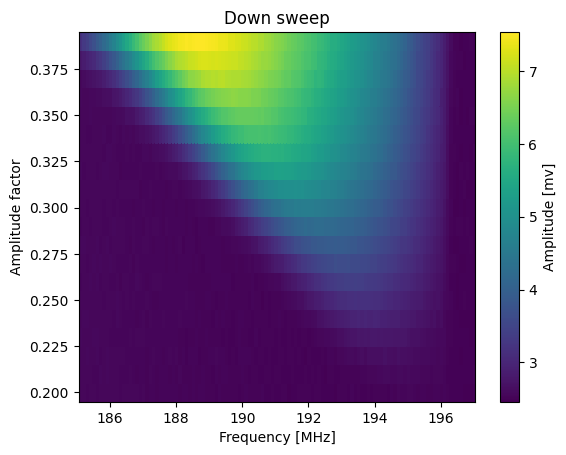

In [172]:
%matplotlib inline 

plt.clf()
fig, ax = plt.subplots(1, 1)

ax.set_title("Down sweep")
c=ax.pcolor(f / u.MHz, amp_factor, np.sqrt(Id**2+Qd**2)*1e3) # What is shown is normalized by dividing by the amplitude 
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Amplitude factor")
fig.colorbar(c,ax=ax, label="Amplitude [mv]")

### Saving downseep

In [ ]:
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="Spectrum_QM" #second folder 
name="Map_downsweep" # third folder 
meastype="filename" #Final file name 

datadict={}
#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

#Saving of parameters 
datadict["n_repetition"]=n_rep
datadict["amp_factor"]=amp_factor
datadict["Readout_Len"]=Readout_Len
datadict["wait_pump_step"]=cooldown_time
datadict["IF_pump"]=IF_pump
datadict["IF_right"]=IF_right
datadict["pump_step"]=pump_step

#Saving of data 
datadict["freqs"]=f
datadict["I"]=I
datadict["Q"]=Q
datadict["config"]=config

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

# Upsweep 

## Upsweep single 

In [ ]:
Readout_Len=10_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=10_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

amp_factor=0.4

n_repetition=1_000

IF_pump=196.8e6 #where we go  
IF_left=195.8e6  # whre we start
pump_step=0.02e6
wait_pump_step=400//4 #waiting time after having played the pump 

number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

In [56]:

%matplotlib qt


with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    

    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        update_frequency("fluxline", IF_left)
        play("pumping"*amp(amp_factor), "fluxline") #play a first pump to define the initial frequency and amplitude factor

        with for_(f, IF_left, f<IF_pump, f+pump_step):

            assign(f_readout,LO_diff+f/2) #update the readout frequency 
            update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

            update_frequency("fluxline", f, keep_phase=True)


            play("pumping"*amp(0), "fluxline")


        #Continously measure in paralell
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            wait(wait_pump_step, "fluxline") #time that will be waited after playing the pump 

            assign(I,Math.abs(I))
            assign(Q,Math.abs(Q))

            save(I, I_st)
            save(Q, Q_st)  
            save(f, f_st)

        ramp_to_zero("fluxline")

        save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).average().save("I")
        Q_st.buffer(number_frequency).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False   

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'3'})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        Id = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Qd = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.plot(f,np.sqrt(Id**2+Qd**2),".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
       

Execution stopped by user!
2023-04-25 21:53:25,960 - qm - INFO - Flags: 
2023-04-25 21:53:25,961 - qm - INFO - Sending program to QOP
2023-04-25 21:53:26,441 - qm - INFO - Executing program


## Up sweep map 

In [175]:
%matplotlib qt
Readout_Len=10_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=10_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

a_min=0.1
a_max=0.4
da=0.01
amp_factor=np.arange(a_min,a_max,da)

n_repetition=1_000

IF_pump=196.6e6 #where we go  
IF_left=195.8e6  # whre we start
pump_step=0.01e6

wait_pump_step=400//4 #waiting time after having played the pump 

number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

time_per_iteration=((wait_pump_step+twoPhoton_len)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition*len(amp_factor)/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

2023-04-26 14:43:33,169 - qm - WARNING - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 
2023-04-26 14:43:33,170 - qm - WARNING - Open QM ended with warning 0: Quantum Machine qm-1682512979501 is canceling running job 1682423160879.
Time per iteration : 0.000808 s
Total time : 0.4174666666666667 min


In [176]:

with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    a= declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    
    # Averaging loop  
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        #loop over amplitude 
        with for_(*from_array(a, amp_factor)):
        
            #Play the first pulse of the sticky to set the pump frequency and the amplitude 
            update_frequency("fluxline", IF_right)
            play("pumping"*amp(a), "fluxline") 

            #loop over frequencies  
            with for_(f, IF_left, f<IF_pump, f+pump_step):

                assign(f_readout,LO_diff+f/2) #update the readout frequency 
                update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

                #update the sticky 
                update_frequency("fluxline", f, keep_phase=True)
                play("pumping"*amp(0), "fluxline")

            #Continously measure in paralell
                measure(
                    "fake_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                wait(wait_pump_step, "fluxline") #time that will be waited after playing the pump 

                #Take absolute value of I and Q
                assign(I,Math.abs(I))
                assign(Q,Math.abs(Q))

                save(I, I_st)
                save(Q, Q_st)  
                save(f, f_st)

            #ramp to zero 
            ramp_to_zero("fluxline")

        save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("I")
        Q_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False     

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'3'})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        I = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.pcolor(f / u.MHz, amp_factor, np.sqrt(I**2+Q**2)*1e3)
       # plt.plot(f/1e6,np.sqrt(Id**2+Qd**2)*1e3,".", markersize=2)
        plt.xlabel("Pump frequency [MHz]")
        plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
        plt.pause(0.1)

2023-04-26 14:43:33,744 - qm - INFO - Flags: 
2023-04-26 14:43:33,745 - qm - INFO - Sending program to QOP
2023-04-26 14:43:34,219 - qm - INFO - Executing program


Execution stopped by user!


<Figure size 640x480 with 0 Axes>

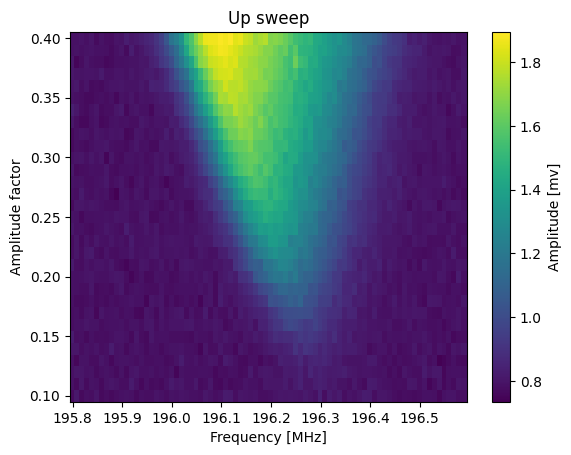

In [178]:
%matplotlib inline 
plt.clf()
fig, ax = plt.subplots(1, 1)

ax.set_title("Up sweep")
c=ax.pcolor(f / u.MHz, amp_factor, np.sqrt(I**2+Q**2)*1e3) # What is shown is normalized by dividing by the amplitude 
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Amplitude factor")
fig.colorbar(c,ax=ax, label="Amplitude [mv]")

### Saving upsweep 

In [ ]:
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="Spectrum_QM" #second folder 
name="Map_upsweep" # third folder 
meastype="filename" #Final file name 

datadict={}
#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

#Saving of parameters 
datadict["n_repetition"]=n_rep
datadict["amp_factor"]=amp_factor
datadict["Readout_Len"]=Readout_Len
datadict["wait_pump_step"]=cooldown_time
datadict["IF_pump"]=IF_pump
datadict["IF_left"]=IF_left
datadict["pump_step"]=pump_step

#Saving of data 
datadict["freqs"]=f
datadict["I"]=I
datadict["Q"]=Q
datadict["config"]=config

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

# Steady state 

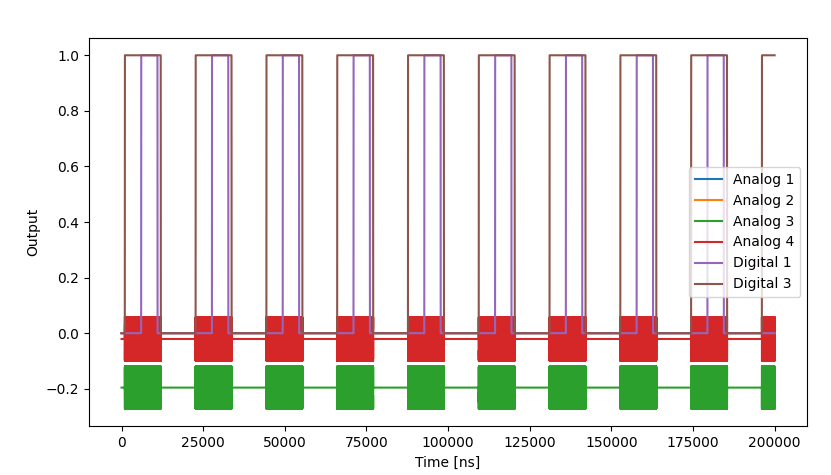

Here, to get the steady state, we apply the pump at a given frequency and wait (pulse_delay_ss) time before making the readout with the readout len. Therefore, the resonator waiting must be larger than the Readout lengt. Since the pulse is looped, multiple times, we can keep it to a length of 1_000. After the readout has been down, the pulse is stopped for a time cooling_down.

## Steady state single 

In [124]:

Readout_Len=10_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


# Test sticky

amp_factor=0.3


n_repetition=1000

IF_pump=196.6e6 #where we go  
IF_left=195.8e6  # where we start
pump_step=0.02e6


number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

pulse_delay_ss= 10_000_000 # to to play the pulse before making a last probe 

resonator_waiting=(pulse_delay_ss-Readout_Len)//4

cooling_down= 10_000_000 //4 #time between succesinve frequencies 


time_per_iteration=((pulse_delay_ss+cooling_down*4)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

Time per iteration : 0.8 s
Total time : 13.333333333333334 min


In [125]:
%matplotlib qt

with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    i = declare(int)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    

    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        

        with for_(f, IF_left, f<IF_pump, f+pump_step):

            assign(f_readout,LO_diff+f/2) # update the readout frequency 
            update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

            update_frequency('fluxline_unstick', f, keep_phase=True)


            with for_(i, 0, i <pulse_delay_ss/twoPhoton_len+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle
                play("pumping" * amp(amp_factor), 'fluxline_unstick')  # Play the pulse on the fluxline

            wait(resonator_waiting,"resonator")    

            measure(
            "fake_readout",
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            wait(cooling_down)



            assign(I,Math.abs(I))
            assign(Q,Math.abs(Q))

            save(I, I_st)
            save(Q, Q_st)  
            save(f, f_st)


        save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).average().save("I")
        Q_st.buffer(number_frequency).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False  

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={"1","3"})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

    
else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        Id = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Qd = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.plot(f,np.sqrt(Id**2+Qd**2),".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)

2023-04-26 10:10:00,099 - qm - INFO - Flags: 
2023-04-26 10:10:00,100 - qm - INFO - Sending program to QOP
2023-04-26 10:10:00,715 - qm - INFO - Executing program
Execution stopped by user!


## Steady state map

In [179]:
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


# Test sticky

a_min=0.1
a_max=0.4
da=0.01
amp_factor=np.arange(a_min,a_max,da)

#amp_factor=np.array([0.2,0.25,0.3,0.35,0.4])

n_repetition=1000

IF_pump=196.6e6 #where we go  
IF_left=195.8e6  # where we start
pump_step=0.02e6


number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

pulse_delay_ss= 1_000_000 # to to play the pulse before making a last probe 

resonator_waiting=(pulse_delay_ss-Readout_Len)//4

cooling_down= 1_000_000 //4 #time between succesinve frequencies 


time_per_iteration=((pulse_delay_ss+cooling_down*4)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition*len(amp_factor)/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

Time per iteration : 0.08 s
Total time : 41.333333333333336 min


In [180]:
%%time

with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    i = declare(int)
    a = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    

    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        #loop over amplitude 
        with for_(*from_array(a, amp_factor)):
        
            with for_(f, IF_left, f<IF_pump, f+pump_step):

                assign(f_readout,LO_diff+f/2) # update the readout frequency 
                update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

                update_frequency('fluxline_unstick', f, keep_phase=True)


                with for_(i, 0, i <pulse_delay_ss/twoPhoton_len+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle
                    play("pumping" * amp(a), 'fluxline_unstick')  # Play the pulse on the fluxline

                wait(resonator_waiting,"resonator")    

                measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                wait(cooling_down)



                assign(I,Math.abs(I))
                assign(Q,Math.abs(Q))

                save(I, I_st)
                save(Q, Q_st)  
                save(f, f_st)


            save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("I")
        Q_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False  

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={"1","3"})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

    
else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        Id = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Qd = u.demod2volts(Q, Readout_Len)
        
        norm=np.sqrt(Id**2+Qd**2)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.pcolor(f / u.MHz, amp_factor, np.sqrt(Id**2+Qd**2)*1e3)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)

2023-04-26 14:44:42,249 - qm - INFO - Flags: 
2023-04-26 14:44:42,250 - qm - INFO - Sending program to QOP
2023-04-26 14:44:43,213 - qm - INFO - Executing program


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:128.178.175.167:81 {grpc_message:"Stream removed", grpc_status:2, created_time:"2023-04-26T13:09:51.842384623+00:00"}"
>

Execution stopped by user!


Traceback (most recent call last):
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\matplotlib\cbook\__init__.py", line 287, in process
    func(*args, **kwargs)
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\qualang_tools\plot\plot.py", line 356, in on_close
    current_job.halt()
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\qm\QmJob.py", line 198, in halt
    response = self._frontend.Halt(request)
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\grpc\_interceptor.py", line 252, in __call__
    compression=compression)
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\grpc\_interceptor.py", line 290, in _with_call
    return call.result(), call
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\grpc\_channel.py", line 343, in result
    raise self
  File "C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\grpc\_interceptor.py", line 280, in conti

<Figure size 640x480 with 0 Axes>

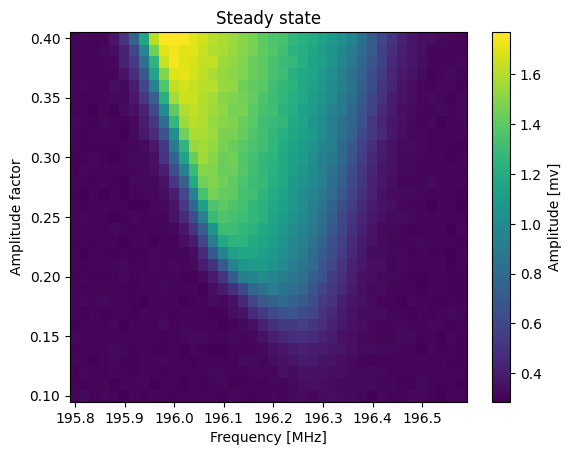

In [182]:
%matplotlib inline 
plt.clf()
fig, ax = plt.subplots(1, 1)

ax.set_title("Steady state")
c=ax.pcolor(f / u.MHz, amp_factor, np.sqrt(Id**2+Qd**2)*1e3) # What is shown is normalized by dividing by the amplitude 
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Amplitude factor")
fig.colorbar(c,ax=ax, label="Amplitude [mv]")

## Plotting amplitude cut 

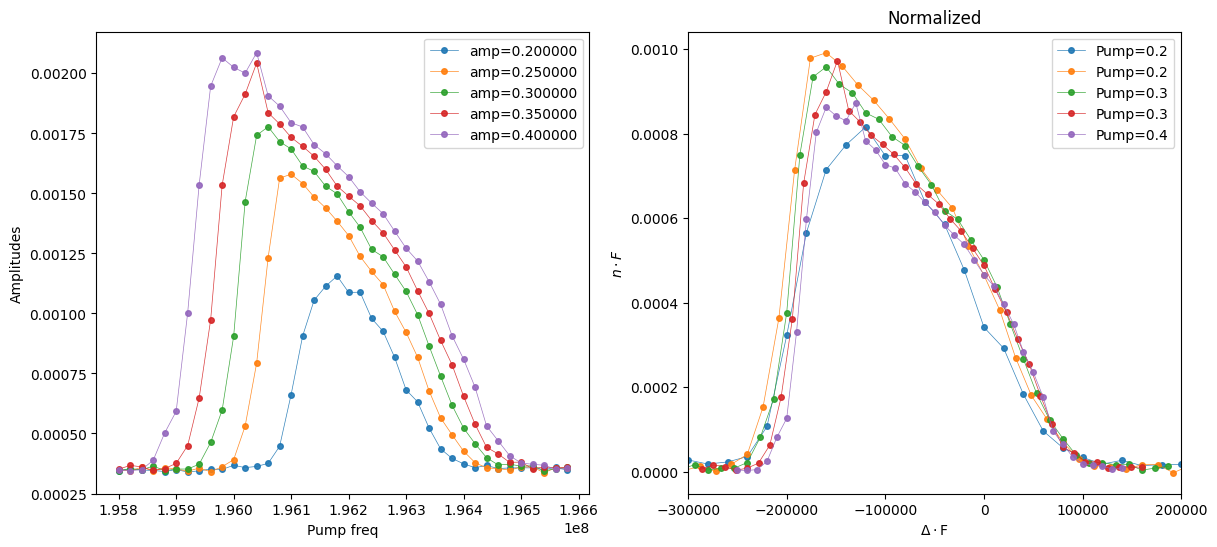

In [167]:
%matplotlib inline 

fig, axs = plt.subplots( ncols=2, figsize=(14,6))
ax=axs[0]


for i in range(norm.shape[0]):
    ax.plot(f,norm[i,:],'.-',label=f'amp={amp_factor[i]:1f}', alpha=.9, lw=.5, ms=8)
  
ax.set_xlabel("Pump freq")
ax.set_ylabel("Amplitudes")
ax.legend()

ax=axs[1]
Gi=0.2
center_freq=4348150000*2  
offset=0.00034

for i in range(norm.shape[0]):
    Gx=amp_factor[i]
    Pump_freq=f+LO_fluxline
    ax.plot((Pump_freq-center_freq)*Gi/Gx,(norm[i,:]-offset)*Gi/Gx, '.-',  label=f'Pump={amp_factor[i]:.1f}', alpha=.9, lw=.5, ms=8)

ax.set_title("Normalized")
ax.set_xlabel('$\Delta\cdot$F')
ax.set_ylabel('$n\cdot F$')
ax.set_xlim((-3e5,2e5))
ax.legend()

    

# Spectrum Analyzer 

Not ready 

In [ ]:
%matplotlib qt
from scipy import signal

n_runs = 1000

cooldown_time = 16000 // 4 # Waiting time before playing the new pulse 

amp_factor=0.4 #amplitude factor 

# Frequency sweep in Hz
span=10 * u.kHz
df = 100 * u.Hz
freqs = np.arange(IF_readout-span, IF_readout+span, df) 

# Resonance frequency 
IF_pump=0.19575e9
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

LO_diff=LO_fluxline/2-LO_readout

i_runs = n_runs * len(freqs)


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)

    # Starts playing on the fluxline 
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline_unstick') #Play the pulse on the fluxline  
    
    with for_(n, 0, n < n_runs, n + 1):
        
        #Sweep the domudlation frequency 
        with for_(*from_array(f,freqs)):
            
            #Update the demodulation frequency 
            update_frequency("resonator",IF_resonator+Offset_IF) 
            
            
            update_frequency("resonator",f) #change the demodulation frequency 
            reset_phase("resonator")
            
            #Measure at the output 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, "resonator")

    with stream_processing():
        I_st.buffer(len(freqs)).average().save("I") #Continously average the different buffers of size len(freqs)
        Q_st.buffer(len(freqs)).average().save("Q")

        
        
simulation = False
if simulation:
    simulation_config = SimulationConfig(
        duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else:
  

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        I = u.demod2volts(I, pulse_len)
        Q = u.demod2volts(Q, pulse_len)

        #plt.subplot(211)
        
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(freqs-IF_readout, np.sqrt(Q**2+I**2), "-", markersize=2) #Plot the power vs IF frequency readout 
        plt.xlabel("freqs")
        plt.ylabel("Power")
        plt.subplot(212)
        plt.cla()
        plt.plot(freqs-IF_readout, signal.detrend(np.unwrap(np.angle(I+1j*Q))), "-", markersize=2) #plot the phase 
        plt.pause(0.1)
        #plt.axis("equal")
        #job.halt()

# Previous 

In [60]:
%matplotlib qt


Readout_Len=1_000_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


# Test sticky

amp_factor=0.3
freqs_array=np.array([[ 0.1950e9]]) # defines the IF of the pump  0.19565
IF_pump=freqs_array[0,0] #select the desired pump frequency 


IF_pump=191.5e6 
IF_right=197.5e6 # Pump IF very much on the right 
pump_step=0.0357e6
wait_pump_step=400//4 #waiting time after having played the pump 


LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 


with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    
    update_frequency("fluxline", IF_right)
    play("pumping"*amp(amp_factor), "fluxline") #play a first pump to define the initial frequency and amplitude factor
   
    with for_(f, IF_right, f>IF_pump, f-pump_step):
        
        assign(f_readout,LO_diff+f/2) #update the readout frequency 
        update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 
  
        update_frequency("fluxline", f, keep_phase=True)
        
        
        play("pumping"*amp(0), "fluxline")
        
        
    #Continously measure in paralell
        measure(
            "fake_readout",
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
        )

        wait(wait_pump_step, "fluxline") #time that will be waited after playing the pump 
        
        
        save(I, I_st)
        save(Q, Q_st)
        save(f, f_st)
       
    ramp_to_zero("fluxline")


    with stream_processing():
        I_st.save_all("I")
        Q_st.save_all("Q")
        f_st.save_all("f")

    
    

simulation = False     

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'3'})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I", "Q","f"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I, Q,f = results.fetch_all()

        Id = u.demod2volts(I, Readout_Len) #diviser par la duree du pulse Readout_lEN 
        Qd = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        #fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
        plt.cla()
        plt.plot(f,np.sqrt(Id**2+Qd**2),".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
       
        

Execution stopped by user!
2023-04-25 19:38:29,486 - qm - INFO - Flags: 
2023-04-25 19:38:29,487 - qm - INFO - Sending program to QOP
2023-04-25 19:38:44,820 - qm - INFO - Executing program


In [66]:
len(Id)
IF_pump=191.5e6 
IF_right=197.5e6 # Pump IF very much on the right 
pump_step=0.0357e6

int(np.ceil((IF_right-IF_pump)/pump_step))


169

In [63]:
len(Id)

169

In [15]:
%matplotlib qt

Readout_Len=5_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


amp_factor_array=np.array([0.3]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

amp_factor_high_array=np.array([1.0]) #Prefactor of the amplitude 
amp_factor_high=amp_factor_high_array[0]


#Update the pump IF frequency 
freqs_array=np.array([[ 0.1950e9]]) # defines the IF of the pump  0.19565
IF_pump=freqs_array[0,0] #select the frequency from the array 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=2 #number of repetitions 

n_empty=3#number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be on low amp 
n_full=4 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=10_000//4 #cooldown time before each repetition to go back to vacuum  #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

with program() as IQ_blobs:

    n = declare(int)
    n_rep = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)
    n_rep_st=declare_stream()

    assign_variables_to_element("resonator", I,Q) 

    #Update the demodulation frequency 
    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)

    #Loop on the repetition 
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

        #Loop on the repetition 
        
        #play("pumping" * amp(amp_factor_high), 'fluxline', chirp=(250, 'Hz/nsec'))  
        
        with for_(i, 0, i < np.round((n_empty*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor_high), 'fluxline')  

        with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor), 'fluxline')  



        #Demodulation measurements 
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate n time 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)

        save(n_rep, n_rep_st)

        wait(cooldown_time) #wait the cooldown 

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        n_rep_st.save("n_rep")



simulation = True      

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_ylim((100e6,300e6))
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

else:

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():

        I, Q, n_rep = results.fetch_all()

        time_vec=I["timestamp"]
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q["value"], Readout_Len)


        #Plotting the average 
        if len(I)>n_runs:

            #Datas are capted continously and then transfer into a 2D matrix and averaged
            it=len(I)//n_runs
            I_2d=I[0:it*n_runs].reshape((it,n_runs))
            Q_2d=Q[0:it*n_runs].reshape((it,n_runs))
            norm_2d=np.sqrt(I_2d**2+Q_2d**2)

            plt.subplot(211)
            fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
            plt.cla()
            plt.plot(np.angle(I_2d[it-1,:]+1j*Q_2d[it-1,:]), ".", markersize=2)
            plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
            plt.xlabel("Nb points")
            plt.ylabel("phase")
            plt.pause(0.1)


            plt.subplot(212)
            av=np.mean(norm_2d,axis=0) 
            plt.subplot(313)
            plt.cla()
            plt.plot(time[0:n_runs]*1e-9,av*1e3,".",markersize=2)
            plt.xlabel("time [s]")
            plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")





2023-04-25 17:22:52,810 - qm - INFO - Flags: 
2023-04-25 17:22:52,810 - qm - INFO - Simulating program


C:\Users\hqclabo\Anaconda3\envs\Measurement\lib\site-packages\ipykernel_launcher.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator


## Plotting for single frequency 


In [7]:
time

<module 'time' (built-in)>

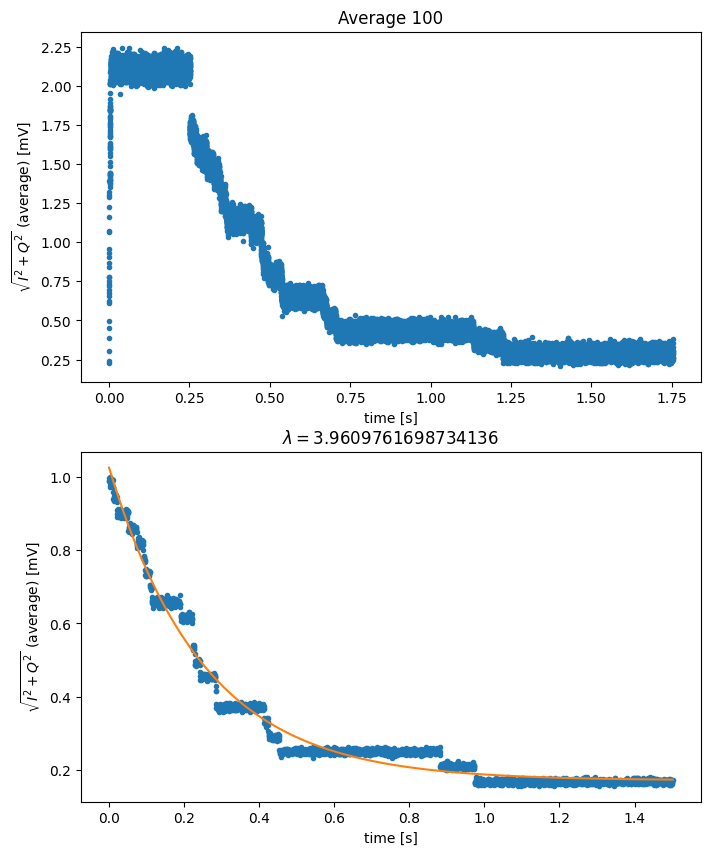

In [98]:
%matplotlib inline
number_avg=10
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_array,Pump_Delay,number_avg)

amp_factor=amp_factor_array[0]
freqs=freqs_array[0,:]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3,".")
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("$\lambda= $"+str(gap))
        ax.plot(time_fit,av_fit,".")
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        
        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3)
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

In [71]:
%matplotlib qt

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


amp_factor_array=np.array([0.6]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

amp_factor_high_array=np.array([1]) #Prefactor of the amplitude 
amp_factor_high=amp_factor_high_array[0]


#Update the pump IF frequency 
freqs_array=np.array([[ 0.19565e9]]) # defines the IF of the pump  
IF_pump=freqs_array[0,0]
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=20 #number of repetitions 

n_empty=5_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=5_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  


with program() as IQ_blobs:

    n = declare(int)
    n_rep = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)
    n_rep_st=declare_stream()

    assign_variables_to_element("resonator", I,Q) 

    #Update the demodulation frequency 
    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)
    
    #Loop on the repetition 
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

        #Loop on the repetition 
        with for_(i, 0, i < np.round((n_empty*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor_high), 'fluxline')  

        with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor), 'fluxline')  



        #Demodulation measurements 
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate n time 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)

        save(n_rep, n_rep_st)

        wait(cooldown_time) #wait the cooldown 

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        n_rep_st.save("n_rep")



simulation = False     

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

else:

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        I, Q, n_rep = results.fetch_all()

        #dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        time=I["timestamp"]
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q["value"], Readout_Len)

        plt.subplot(211)
        plt.cla()
        fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        plt.plot(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        #plt.plot(I**2+Q**2,".",markersize=2)
        plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)




2023-04-21 18:02:13,192 - qm - INFO - Flags: 
2023-04-21 18:02:13,193 - qm - INFO - Sending program to QOP
2023-04-21 18:02:13,748 - qm - INFO - Executing program
Execution stopped by user!


In [59]:
I_2d=I.reshape((n_repetition,n_runs))
Q_2d=Q.reshape((n_repetition,n_runs))
time_2d=time.reshape((n_repetition,n_runs))

norm_2d=np.sqrt(I_2d**2+Q_2d**2)
#We reset the timer to zero for each idx
time_2d=(time_2d.transpose()-time_2d[:,0]).transpose()


Text(0, 0.5, "r'$I^2 + Q^2$ (average) [V]")

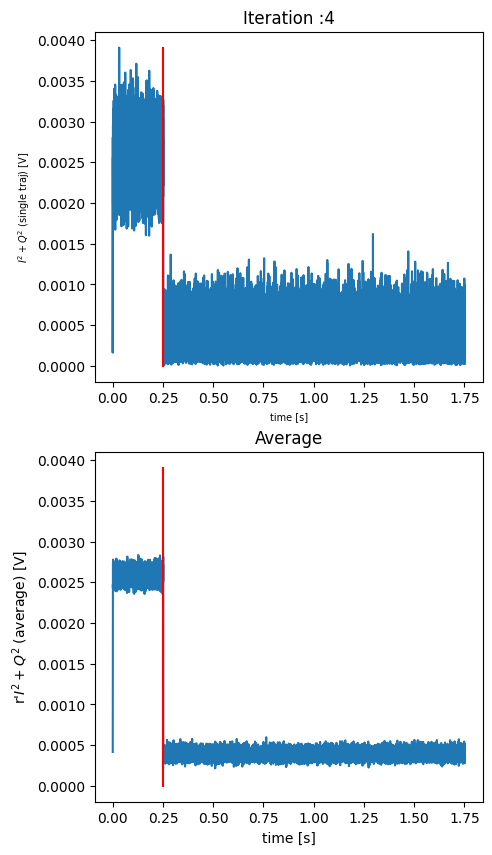

In [60]:
%matplotlib inline
idx=4
fontsize=7
fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)

ax=axs[0]
ax.set_title("Iteration :" + str(idx))
ax.plot(time_2d[idx,:]*1e-9,norm_2d[idx,:])
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(norm_2d[idx,:])],"r")
ax.set_ylabel(r'$I^2 + Q^2$ (single traj) [V]',fontsize=fontsize)
ax.set_xlabel("time [s]",fontsize=fontsize)
#average over all axis :
ax=axs[1]
ax.set_title("Average")
av=np.mean(norm_2d,axis=0)
ax.plot(time_2d[0,:]*1e-9,av)
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(norm_2d[idx,:])],"r")
ax.set_xlabel("time [s]")
ax.set_ylabel("r'$I^2 + Q^2$ (average) [V]")
